In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
# # load the filtered pore-C data
# dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
# cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
# filetags = [f"run0{x}" for x in cellNums]

# assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
# rawCells = pcu.loadRawContactDirectory(dirpath, filetags)

# print("Filtering....")
# adjacent = filters.runAllFilters(rawCells,
#                               assembly,
#                               adjacent=True,
#                               chromosome=None, 
#                               verbose=False)  

# print(f"\n{adjacent.keys()=}")

In [4]:
# # combine the adjacent contact structure
# adjDfList = []

# for k, v in adjacent.items():
#     v['cell'] = k
#     v['filterType'] = 'adjacent'
#     adjDfList.append(v)
    
# adjDf = pd.concat(adjDfList, ignore_index=True)
# print(f"{adjDf.shape=}")
# print()
# adjDf.columns

In [5]:
# savepath = "filtered_data/adjacent1MBfiltered.csv"

# adjDf.to_csv(savepath, index=False)
# print('done')

In [6]:
filepath = "filtered_data/adjacent1MBfiltered.csv"

adjDf = pd.read_csv(filepath)
adjDf['filterType'] = 'adjacent'

print(f"{adjDf.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


adjDf.shape=(286943, 66)


In [7]:
filepath = "filtered_data/clique1MBfiltered.csv"

cliqDf = pd.read_csv(filepath)
cliqDf['filterType'] = 'expanded'

print(f"{cliqDf.shape=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


cliqDf.shape=(636130, 66)


In [8]:
# combine the datasets

df = pd.concat([adjDf, cliqDf], ignore_index=True)
print(f"{df.shape=}")
df['filterType'].value_counts()

df.shape=(923073, 66)


expanded    636130
adjacent    286943
Name: filterType, dtype: int64

In [9]:
resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

adj1mb = {}
exp1mb = {}

for cell in df['cell'].unique():
    
    cellAdj = df[(df['cell'] == cell) & (df['filterType'] == 'adjacent')].reset_index(drop=True)
    cellExp = df[(df['cell'] == cell) & (df['filterType'] == 'expanded')].reset_index(drop=True)
    
    cellAdjBinned = binning.wholeGenomeBinData(cellAdj, bins, label1, label2)
    cellExpBinned = binning.wholeGenomeBinData(cellExp, bins, label1, label2)
    
    Aadj = pcu.getHic(cellAdjBinned, bins, label1, label2)
    Aexp = pcu.getHic(cellExpBinned, bins, label1, label2)
    
    print(f"{cell=} {Aadj.shape=} {Aexp.shape=}")
    
    adj1mb[cell] = Aadj
    exp1mb[cell] = Aexp
    
print('done.')

cell='run01' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run02' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run04' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run05' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run06' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
cell='run07' Aadj.shape=(2724, 2724) Aexp.shape=(2724, 2724)
done.


In [10]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)

filteredPoreCIndex = list(range(0, len(adj1mb['run01'])))

In [11]:
filteredPoreCIndex = list(range(0, len(adj1mb['run01'])))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=2724


In [12]:
chromosome = ['chr2']

chrom2 = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = np.where(A > 0, 1, 0)
    np.fill_diagonal(A, 1)
    return A
    

for runId in adj1mb.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Aadj = processMat(adj1mb[runId], ind)
    Aexp = processMat(exp1mb[runId], ind)
    
    chrom2[runId] = {
        'adjacent' : Aadj,
        'expanded' : Aexp
    }
    
    
print('done.')

done.


In [13]:
c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_black= matplotlib.colors.colorConverter.to_rgba('black',alpha = 1)
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap1',[c_white,c_black],512)


c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
c_other = matplotlib.colors.colorConverter.to_rgba('red',alpha = 1)
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('cmap2',[c_white,c_other],512)

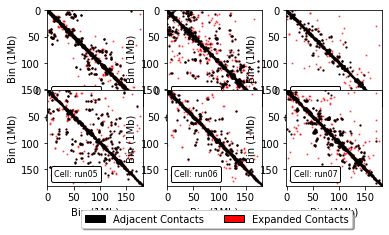

In [14]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 12, 12

fig = plt.figure()
legend_elements = [Patch(facecolor='k', edgecolor='k', label='Adjacent Contacts'),
                   Patch(facecolor=c_other, edgecolor='k', label='Expanded Contacts')]

pltNum = 0
for runId, mats in chrom2.items():
    pltNum += 1
    
    fig.add_subplot(2, 3, pltNum)
    
    plt.spy(mats['expanded'], c='red', alpha=0.5, marker='s', markersize=1)
    plt.spy(mats['adjacent'], c='k', marker='s', markersize=1)
    
    plt.xlabel('Bin (1Mb)')
    plt.ylabel('Bin (1Mb)')
    
    
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_aspect('equal')
    
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(-.73, -0.2),
          fancybox=True, shadow=True, ncol=5)
    
plt.subplots_adjust(wspace=0.25, hspace=-0.42)

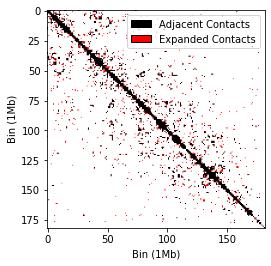

In [15]:
adjEnsemble = np.zeros((182, 182))
expEnsemble = np.zeros((182, 182))

for runId, mats in chrom2.items():
    adjEnsemble += mats['adjacent']
    expEnsemble += mats['expanded']
    
adjEnsemble = np.where(adjEnsemble > 0, 1, 0)
expEnsemble = np.where(expEnsemble > 0, 1, 0)

plt.imshow(expEnsemble, cmap=cmap2)
plt.imshow(adjEnsemble, cmap=cmap1)
    
plt.legend(handles=legend_elements)
plt.xlabel('Bin (1Mb)')
plt.ylabel('Bin (1Mb)')

ax = plt.gca()
ax.set_aspect('equal')

# trans contacts

In [16]:
chromosome = ['chr1', 'chr2']

chroms = {}

def processMat(fullMat, ind):
    """streamline a few procedures on both datasets"""
    A = fullMat[:, ind][ind, :]
    A = np.where(A > 0, 1, 0)
    np.fill_diagonal(A, 1)
    return A
    

for runId in adj1mb.keys():
    
    ind = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

    Aadj = processMat(adj1mb[runId], ind)
    Aexp = processMat(exp1mb[runId], ind)
    
    chroms[runId] = {
        'adjacent' : Aadj,
        'expanded' : Aexp
    }
    
    
print('done.')

done.


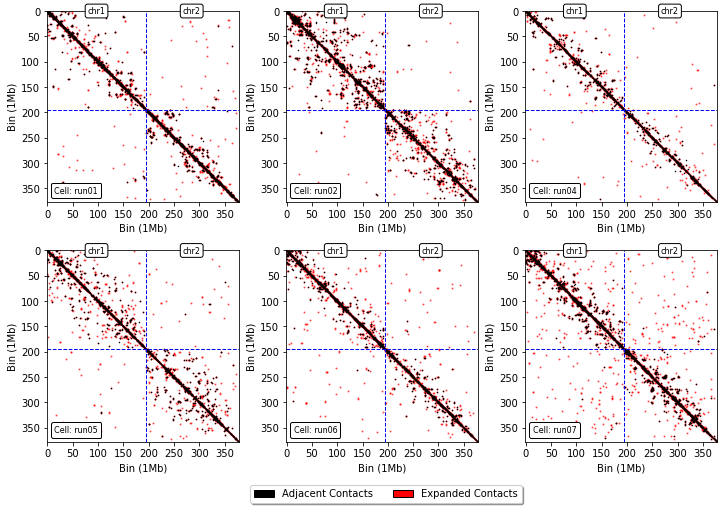

In [17]:
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 12, 12

fig = plt.figure()
legend_elements = [Patch(facecolor='k', edgecolor='k', label='Adjacent Contacts'),
                   Patch(facecolor=c_other, edgecolor='k', label='Expanded Contacts')]

pltNum = 0
for runId, mats in chroms.items():
    pltNum += 1
    
    fig.add_subplot(2, 3, pltNum)
    
    plt.spy(mats['expanded'], c='red', alpha=0.5, marker='s', markersize=1)
    plt.spy(mats['adjacent'], c='k', marker='s', markersize=0.5)
    
    plt.xlabel('Bin (1Mb)')
    plt.ylabel('Bin (1Mb)')
    
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    
    at = AnchoredText(
        f"Cell: {runId}", prop=dict(size=8), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    ax.set_aspect('equal')
    
    cnt = 0
    for i, chrm in enumerate(chromosome):    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position

        pos = row['length'].values[0] - 1
        testPos = (pos // 2 ) + cnt
        cnt += pos
    
        
        ax.annotate(f"{chrm}", xy=(testPos, 0), xycoords="data",
                          va="center", ha="center", size=8,
                          bbox=dict(boxstyle="round", fc="w") ) 

        if i < len(chromosome) -1:
            ax.axhline(y=cnt, lw=1, ls='--', c='b')    
            ax.axvline(x=cnt, lw=1, ls='--', c='b')  


plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(-.73, -0.2),
          fancybox=True, shadow=True, ncol=5)

plt.subplots_adjust(wspace=0.25, hspace=-0.42)

# Full trans picture

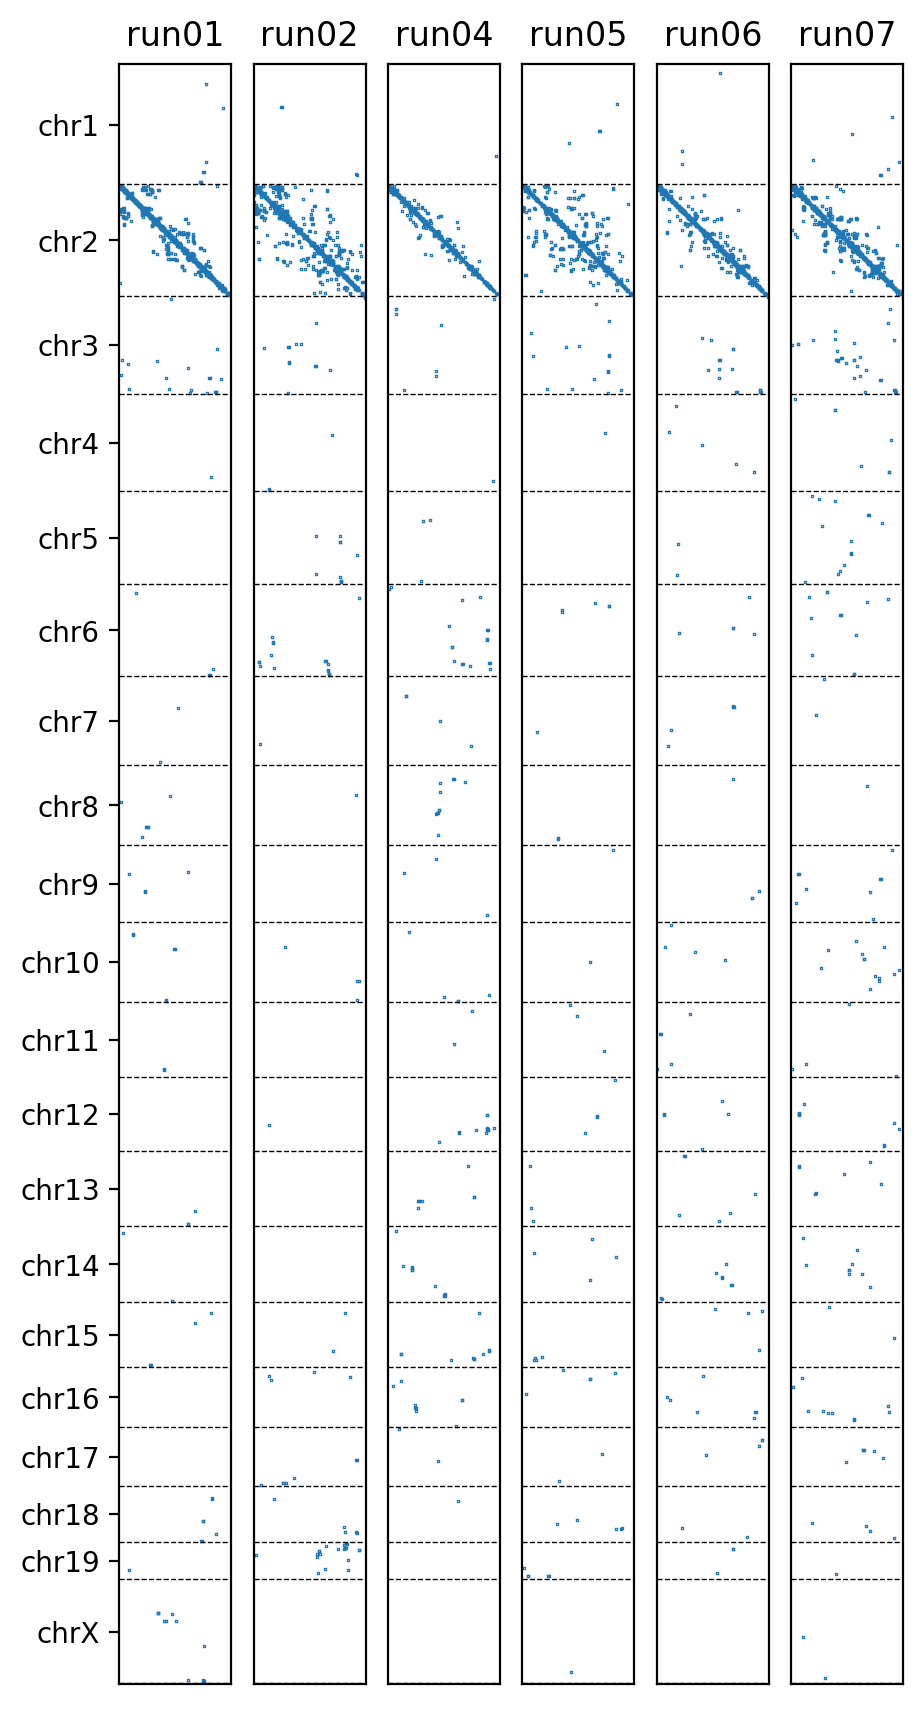

In [22]:
chromosome = ['chr2']
colIndex = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 13


fig = plt.figure()
figCount = 0

for runId in adj1mb.keys():
    adjMat = adj1mb[runId]
    expMat = exp1mb[runId]
    
    transAdj = adjMat[0:2633, colIndex]
    transAdj = np.where(transAdj > 0, 1, 0)
    
    transExp = expMat[0:2633, colIndex]
    transExp = np.where(transExp > 0, 1, 0)
    
    
    figCount += 1 
    fig.add_subplot(1, len(adj1mb), figCount)
    
#     plt.spy(transExp, marker='s', c='C1', markersize=0.2)
    plt.spy(transAdj, marker='s', c='C0', markersize=0.2)
    
    cnt = 0
    
    ytick = []
    ytickLabels = []
    
    for chrm in chromOrder[:-1]:    
        row = filteredChromInfo.loc[filteredChromInfo['region'] == chrm]
        # remap to shuffled chrom position
        pos = row['length'].values[0] - 1
        cnt += pos
        
        ytick.append(cnt - pos // 2)
        ytickLabels.append(chrm)

        plt.axhline(y=cnt, lw=0.5, ls='--',  c='k')    
        
    plt.xticks([], [])
    plt.title(f"{runId}", y=1.001)
    if figCount == 1:
        plt.yticks(ytick, ytickLabels)
    else:
        plt.yticks([], [])

plt.subplots_adjust(left=0.01,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.01)    

In [19]:
df.columns

Index(['index', 'read_name', 'read_length', 'read_idx', 'contact_is_direct',
       'contact_is_cis', 'contact_read_distance', 'contact_genome_distance',
       'contact_fragment_adjacent', 'contact_fragment_distance',
       'haplotype_pair_type', 'align1_align_idx', 'align1_chrom',
       'align1_start', 'align1_end', 'align1_strand', 'align1_mapping_quality',
       'align1_align_score', 'align1_align_base_qscore', 'align1_phase_set',
       'align1_phase_qual', 'align1_haplotype', 'align1_fragment_id',
       'align1_fragment_start', 'align1_fragment_end', 'align2_align_idx',
       'align2_chrom', 'align2_start', 'align2_end', 'align2_strand',
       'align2_mapping_quality', 'align2_align_score',
       'align2_align_base_qscore', 'align2_phase_set', 'align2_haplotype',
       'align2_fragment_id', 'align2_fragment_start', 'align2_fragment_end',
       'batch_id', 'align1_chromosome_name', 'align1_chrom_length',
       'align1_genbank', 'align1_refSeq', 'align1_chrom_end',
      